In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "./../../")

In [3]:
from src import utils
from evaluation import evaluate
from training_utils import save_model

In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from torch import optim
from sklearn import metrics
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [5]:
# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
scaler_dict = utils.open_object("./artifacts/feature_scaler.pkl")

In [7]:
config_dict = {}
config_dict['window_size'] = 32
config_dict['learning_rate'] = 0.0002
config_dict['batch_size'] = 12
config_dict['epochs'] = 50
config_dict['device'] = "cuda" if torch.cuda.is_available() else "cpu"
config_dict['input_size'] = 5
config_dict['hidden_size'] = 32
config_dict['output_size'] = config_dict['input_size']
config_dict['lstm_num_layers'] = 3
config_dict['dropout'] = 0.2

In [8]:
class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)


config = Config(dictionary=config_dict)

### (1) Read Data

In [9]:
df = pd.read_parquet("./artifacts/processed_data.parquet")

In [10]:
df = df.sort_values(by='date').reset_index(drop=True)

In [11]:
df = df[df['date'] < "2020-01-01"].copy()

In [12]:
df.tail()

,date,open,high,low,close,volume
5069,2019-12-24,0.603589,0.600527,0.604402,0.603276,0.086608
5070,2019-12-26,0.603902,0.602605,0.605353,0.605524,0.221727
5071,2019-12-27,0.606630,0.603505,0.606324,0.605309,0.230241
5072,2019-12-30,0.605390,0.602388,0.604064,0.603626,0.258524
5073,2019-12-31,0.603131,0.601339,0.604112,0.604108,0.230740


### (2) Split the data into train and test sets

In [13]:
features_cols = ["volume", "high", "low", "open", "close"]

df_data = df[features_cols].copy()

In [14]:
df_data.head()

,volume,high,low,open,close
0,0.028304,0.480709,0.481546,0.481644,0.479795
1,0.071394,0.480709,0.481156,0.481644,0.479990
2,0.129351,0.483017,0.485037,0.484156,0.485023
3,0.139565,0.485494,0.487338,0.489107,0.487883
4,0.096587,0.490750,0.492627,0.493593,0.490523


In [15]:
train_size = int(0.5 * len(df_data))
df_train = df_data[:train_size]
df_test = df_data[train_size:]

### (3) Create Sequence of input and output

In [16]:
# Custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        inputs = torch.tensor(
            self.data[idx:idx+self.window_size], dtype=torch.float32)
        target = torch.tensor(
            self.data[idx+self.window_size], dtype=torch.float32)
        return inputs, target

In [17]:
train_dataset = TimeSeriesDataset(
    data=df_train.values, window_size=config.window_size)

In [18]:
test_dataset = TimeSeriesDataset(
    data=df_test.values, window_size=config.window_size)

In [19]:
train_loader = DataLoader(train_dataset, config.batch_size,
                          shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset,
                         config.batch_size, shuffle=False)

In [20]:
for inputs, targets in train_loader:
    break

In [21]:
inputs.shape  # batch_size, sequence_len, features

torch.Size([12, 32, 5])

In [22]:
targets.shape  # batch_size, features

torch.Size([12, 5])

### (4) Modeling

In [23]:
criterion = nn.MSELoss()

In [24]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, lstm_num_layers, hidden_size, output_size, device):
        super(BiLSTMModel, self).__init__()
        self.device = device
        self.lstm_num_layers = lstm_num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers=lstm_num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, output_size)
        self.fc2 = nn.Linear(output_size*2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(2*self.lstm_num_layers, x.size(0), self.hidden_size).to(
            self.device)
        c0 = torch.zeros(2*self.lstm_num_layers, x.size(0), self.hidden_size).to(
            self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.fc2(torch.concat([out, x[:, -1, :]], dim=1))
        out = self.sigmoid(out)

        return out

In [25]:
model = BiLSTMModel(input_size=config.input_size, lstm_num_layers=config.lstm_num_layers,
                    hidden_size=config.hidden_size, output_size=config.output_size,
                    device=config.device)

In [26]:
x = torch.randn(config.batch_size, config.window_size, config.input_size)

In [27]:
with torch.no_grad():
    out = model(x)

In [28]:
criterion(out, targets)

tensor(0.0810)

In [29]:
criterion(out[:, -1], targets[:, -1])

tensor(0.0658)

In [30]:
# class self:
#     pass

In [31]:
# input_size = config.input_size
# lstm_num_layers = config.lstm_num_layers
# hidden_size = config.hidden_size
# output_size = config.output_size
# device = config.device

In [32]:
# self.device = device
# self.lstm_num_layers = lstm_num_layers
# self.hidden_size = hidden_size
# self.lstm = nn.LSTM(input_size, hidden_size,
#                     num_layers=lstm_num_layers, batch_first=True, bidirectional=True)
# self.fc = nn.Linear(hidden_size * 2, output_size)
# self.sigmoid = nn.Sigmoid()

In [33]:
# h0 = torch.zeros(2*self.lstm_num_layers, x.size(0), self.hidden_size).to(
#     self.device)
# c0 = torch.zeros(2*self.lstm_num_layers, x.size(0), self.hidden_size).to(
#     self.device)
# out, _ = self.lstm(x, (h0, c0))
# out = self.fc(out[:, -1, :])
# # out = self.sigmoid(out)

In [34]:
# out.shape

In [35]:
# torch.concat([out, x[:, -1, :]], dim=1)

In [36]:
# out[:, -1, :].shape

In [37]:
# x.shape

### (5) Training

In [38]:
scaler = scaler_dict['close']

In [39]:
evaluate(model=model, test_loader=test_loader,
         scaler=scaler, criterion=criterion)

Evaluating:: 100%|██████████| 209/209 [00:00<00:00, 239.75it/s]


{'eval_loss': 0.02399406847978483,
 'eval_price_loss': 0.018334252012303178,
 'eval_MAE': 44.59252}

In [40]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
best_eval_MAE = float("inf")
model_version = "v1"
metrics_list = []
best_model_path = None

In [41]:
total_pbar = tqdm(total=len(train_loader)*config.epochs,
                  desc="Training", position=0, leave=True)

for epoch in range(config.epochs):

    train_loss_list = []
    price_loss_list = []
    prediction_list = []
    ground_truth_list = []

    model = model.train()
    for inputs, targets in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        price_loss = criterion(outputs[:, -1], targets[:, -1])

        loss.backward()
        optimizer.step()

        train_loss_list.append(loss.item())
        price_loss_list.append(price_loss.item())

        yhat = outputs[:, -1].detach().cpu().numpy()
        prediction_list.append(yhat)

        y = targets[:, -1].detach().cpu().numpy()
        ground_truth_list.append(y)

        total_pbar.update(1)

    improve = False
    model_metrics = evaluate(
        model, test_loader, scaler, criterion)
    eval_MAE = model_metrics['eval_MAE']

    if eval_MAE <= best_eval_MAE:
        improve = True
        best_checkpoint = epoch
        best_eval_MAE = eval_MAE

    train_loss = np.mean(train_loss_list)
    train_price_loss = np.mean(price_loss_list)

    predictions = np.concatenate(prediction_list)
    ground_truths = np.concatenate(ground_truth_list)

    predictions = np.exp(scaler.inverse_transform(
        predictions.reshape(-1, 1)))[:, 0]
    ground_truths = np.exp(scaler.inverse_transform(
        ground_truths.reshape(-1, 1)))[:, 0]

    mae = metrics.mean_absolute_error(ground_truths, predictions)
    model_metrics['best_eval_MAE'] = best_eval_MAE

    model_metrics['train_loss'] = train_loss
    model_metrics['train_price_loss'] = train_price_loss
    model_metrics['train_MAE'] = mae

    model_metrics["epoch"] = epoch
    model_metrics["best_epoch"] = best_checkpoint
    metrics_list.append(model_metrics)
    # wandb.log(model_metrics)

    if improve:
        save_dir = os.path.join("models", model_version)
        os.makedirs(save_dir, exist_ok=True)
        model_path = save_model(model, save_dir, epoch, model_metrics)
        best_model_path = model_path

    post_fix_message = {k: round(v, 4) for k, v in model_metrics.items()}
    total_pbar.set_postfix(post_fix_message)


total_pbar.close()
# wandb.finish()

Training:  11%|█         | 1164/10400 [00:24<02:42, 56.93it/s, eval_loss=0.0037, eval_price_loss=0.0004, eval_MAE=7.46, best_eval_MAE=7.46, train_loss=0.002, train_price_loss=0.0004, train_MAE=3.23, epoch=4, best_epoch=4] 

### (6) Validation Model

In [ ]:
df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.set_index("epoch")
df_metrics

,eval_loss,eval_price_loss,eval_MAE,best_eval_MAE,train_loss,train_price_loss,train_MAE,best_epoch
epoch,,,,,,,,
0,0.053319,0.077365,70.417107,inf,0.039050,0.031237,32.659466,0
1,0.050821,0.052539,62.416916,inf,0.010991,0.009960,13.133412,1
2,0.010455,0.003897,22.450438,inf,0.008544,0.006661,11.067995,2
3,0.005315,0.000673,10.397497,inf,0.002826,0.000950,4.588628,3
4,0.003692,0.000413,7.457129,inf,0.002013,0.000435,3.228149,4


<Axes: xlabel='epoch'>

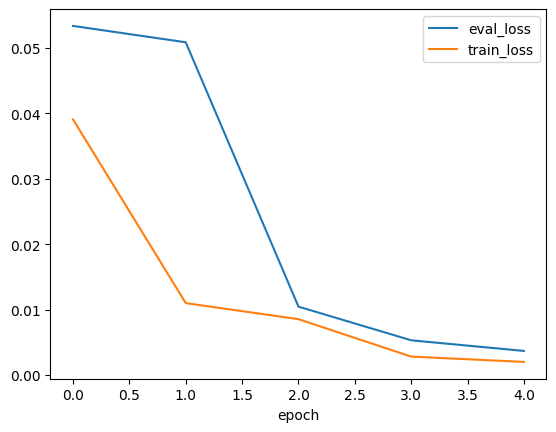

In [ ]:
df_metrics[['eval_loss', 'train_loss']].plot()

<Axes: xlabel='epoch'>

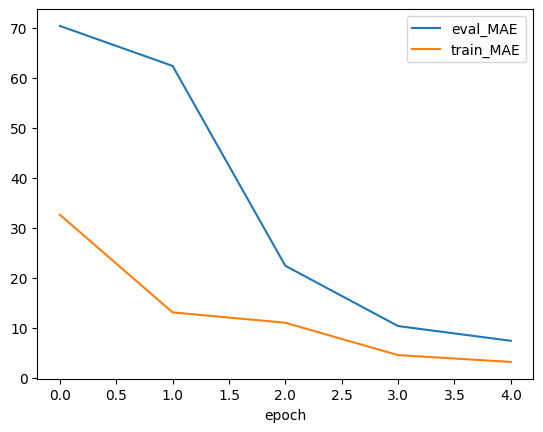

In [ ]:
df_metrics[['eval_MAE', 'train_MAE']].plot()

In [ ]:
best_model = BiLSTMModel(input_size=config.input_size, lstm_num_layers=config.lstm_num_layers,
                         hidden_size=config.hidden_size, output_size=config.output_size,
                         device=config.device)

In [ ]:
best_model_path

'models/v1/579e2791-1b0c-42de-876a-bce3d5d1b862/checkpoint-4/pytorch_model.pt'

In [ ]:
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()
best_model.to(config.device)

BiLSTMModel(
  (lstm): LSTM(5, 32, num_layers=3, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=5, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
evaluate(model=best_model, test_loader=test_loader,
         scaler=scaler, criterion=criterion)

Evaluating:: 100%|██████████| 209/209 [00:00<00:00, 225.39it/s]


{'eval_loss': 0.0036916547241419083,
 'eval_price_loss': 0.0004127258730499237,
 'eval_MAE': 7.4571285}

In [ ]:
best_model.eval()

prediction_list = []
ground_truth_list = []
eval_loss_list = []
price_loss_list = []

dataset_loader = DataLoader(test_dataset, config.batch_size,
                            shuffle=False, drop_last=False)
pbar = tqdm(total=len(dataset_loader),
            desc="Evaluating:", position=0, leave=True)

with torch.no_grad():
    for inputs, targets in dataset_loader:
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)

        price_loss = criterion(outputs[:, -1], targets[:, -1])

        yhat = outputs[:, -1].cpu().numpy()
        prediction_list.append(yhat)

        y = targets[:, -1].cpu().numpy()
        ground_truth_list.append(y)

        eval_loss_list.append(loss.item())
        price_loss_list.append(price_loss.item())

        pbar.update(1)
    pbar.close()

predictions = np.concatenate(prediction_list)
ground_truths = np.concatenate(ground_truth_list)

predictions = np.exp(scaler.inverse_transform(
    predictions.reshape(-1, 1)))[:, 0]
ground_truths = np.exp(scaler.inverse_transform(
    ground_truths.reshape(-1, 1)))[:, 0]

mae = metrics.mean_absolute_error(ground_truths, predictions)

eval_metrics = {}
eval_metrics['eval_loss'] = sum(eval_loss_list)/len(eval_loss_list)
eval_metrics['eval_price_loss'] = sum(price_loss_list)/len(price_loss_list)
eval_metrics['eval_MAE'] = mae

Evaluating:: 100%|██████████| 209/209 [00:01<00:00, 196.35it/s]


In [ ]:
eval_metrics

{'eval_loss': 0.0036916547241419083,
 'eval_price_loss': 0.0004127258730499237,
 'eval_MAE': 7.4571285}

In [ ]:
df_tmp = pd.DataFrame()

In [ ]:
df_tmp['prediction'] = predictions
df_tmp['real'] = ground_truths

In [ ]:
df_tmp.head()

,prediction,real
0,45.930443,45.919998
1,45.685856,45.489998
2,45.377602,44.160000
3,45.136532,44.309990
4,44.888485,44.349995


<Axes: >

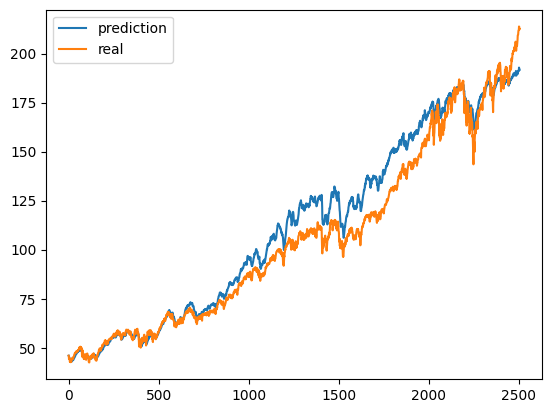

In [ ]:
df_tmp.plot()